In [1]:
import numpy as np
import pandas as pd
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import theano
theano.config.openmp = True

%matplotlib inline
%env OMP_NUM_THREADS=12

Using Theano backend.


env: OMP_NUM_THREADS=12


In [2]:

def create_dataset_lags(dataset, signal, nblags=1):
    df = dataset.copy();
    for i in range(nblags):
        name = signal + "_" + str(i+1);
        df[name] = dataset[signal].shift(i+1);
    return df

In [3]:
def load_dataset(source , signal):
    dataframe = pd.read_csv(source, engine='python')
    return dataframe ;

def get_lag_names(signal, nblags):
    names = [];
    for i in range(nblags):
        name = signal + "_" + str(i+1);
        names.append(name);
    return names;

def cut_dataset(dataframe , signal, lags):
    train_size = int(dataframe.shape[0] * 0.67)
    scaler = MinMaxScaler(); # StandardScaler()
    scaler.fit(dataframe[signal][0:train_size].values.ravel())
    dataframe['scaled_' + signal] = scaler.transform(dataframe[signal].values.ravel())
    lagged_df = create_dataset_lags(dataframe, 'scaled_' + signal, lags)
    (train_df, test_df) = (lagged_df[0:train_size] , lagged_df[train_size:])

    return (scaler, train_df , test_df)

In [4]:
# create and fit the LSTM network

def train_model(train_df , signal, lags, epochs):
    model = Sequential()
    model.add(Dense(40, input_dim=lags))
    # model.add(LSTM(40, input_dim=lags))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    lag_names = get_lag_names('scaled_' + signal , lags);
    N = train_df.shape[0] - lags
    NEstim = (N * 4) // 5;
    trainX = train_df[lag_names][lags:].values
    # trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    trainY = train_df['scaled_' + signal][lags:].values
    estimX = trainX[0:NEstim]
    estimY = trainY[0:NEstim]
    valX = trainX[ NEstim : ]
    valY = trainY[ NEstim : ]

    lStopCallback = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
    lHistory = model.fit(estimX, estimY, nb_epoch=epochs, batch_size=1, validation_data=(valX , valY), verbose=2, 
                        callbacks=[lStopCallback])
    print(lHistory.__dict__)
    return model;

def plot_model(model):
    from IPython.display import SVG
    from keras.utils.visualize_util import model_to_dot

    SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

    

In [5]:
# make predictions

def compute_L2_MAPE(signal , estimator):
    lMean = np.mean( (signal - estimator)**2 );
    lMAPE = np.mean( np.abs((signal - estimator) / signal ));
    lL2 = np.sqrt(lMean);
    return (lL2 , lMAPE);


def predict_signal(model, scaler, signal, nblags, train_df, test_df, idataframe):
    lag_names = get_lag_names('scaled_' + signal , nblags);
    trainX = train_df[lag_names].values
    #trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    trainPredict = model.predict(trainX)
    testX = test_df[lag_names].values
    #testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    testPredict = model.predict(testX)
    trainPredict = scaler.inverse_transform(trainPredict[nblags:])
    testPredict = scaler.inverse_transform(testPredict)
    
    # calculate root mean squared error
    lTrainL2 = compute_L2_MAPE(train_df[signal][nblags:].values, trainPredict)
    lTestL2 = compute_L2_MAPE(test_df[signal].values, testPredict)
    print('TRAIN_TEST_RMSE_MAPE', lTrainL2 , lTestL2)

    out_df = pd.DataFrame()
    out_df = idataframe.copy();
    out_N = out_df.shape[0]
    out_df['Time'] = range(out_N)
    # out_df['scaled_output'] = 0;
    lSeries = pd.Series(np.full(nblags , np.nan));
    lSeries1 = pd.Series(trainPredict.ravel());
    lSeries2 = pd.Series(testPredict.ravel());
    # print(out_N , lSeries.shape[0], lSeries1.shape[0], lSeries2.shape[0])
    lSeries = lSeries.append(lSeries1);
    lSeries = lSeries.append(lSeries2);
    out_df['output'] = lSeries.values;
    out_df['output'] = out_df['output'];
    return out_df;



In [6]:

def full_test(dataset, signal, nblags , epochs):
    full_df = load_dataset(dataset , signal);
    (scaler, train_df, test_df) = cut_dataset(full_df, signal , nblags);
    model = train_model(train_df, signal , nblags, epochs);
    print(model.__dict__)
    plot_model(model);
    out_df = predict_signal(model, scaler, signal, nblags, train_df, test_df, full_df);
    lNewName = signal + "_" + str(nblags) +  "_" + str(epochs) 
    out_df[lNewName] = out_df[signal]
    out_df.plot('Time' , [lNewName,  'output'] , figsize=(22,12));

    
    

/usr/lib/python3/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Train on 96 samples, validate on 24 samples
Epoch 1/100
0s - loss: 0.0696 - val_loss: 0.0351
Epoch 2/100
0s - loss: 0.0423 - val_loss: 0.0413
Epoch 3/100
0s - loss: 0.0436 - val_loss: 0.0305
Epoch 4/100
0s - loss: 0.0278 - val_loss: 0.0336
Epoch 5/100
0s - loss: 0.0309 - val_loss: 0.0280
Epoch 6/100
0s - loss: 0.0305 - val_loss: 0.0258
Epoch 7/100
0s - loss: 0.0291 - val_loss: 0.0293
Epoch 8/100
0s - loss: 0.0194 - val_loss: 0.0226
Epoch 9/100
0s - loss: 0.0220 - val_loss: 0.0214
Epoch 10/100
0s - loss: 0.0214 - val_loss: 0.0220
Epoch 11/100
0s - loss: 0.0174 - val_loss: 0.0234
Epoch 12/100
0s - loss: 0.0226 - val_loss: 0.0220
Epoch 13/100
0s - loss: 0.0170 - val_loss: 0.0208
Epoch 14/100
0s - loss: 0.0165 - val_loss: 0.0203
Epoch 15/100
0s - loss: 0.0153 - val_loss: 0.0197
Epoch 16/100
0s - loss: 0.0139 - val_loss: 0.0262
Epoch 17/100
0s - loss: 0.0195 - val_loss: 0.0338
Epoch 18/100
0s - loss: 0.0158 - val_loss: 0.0201
Epoch 19/100
0s - loss: 0.0166 - val_loss: 0.0213
Epoch 20/100
0s

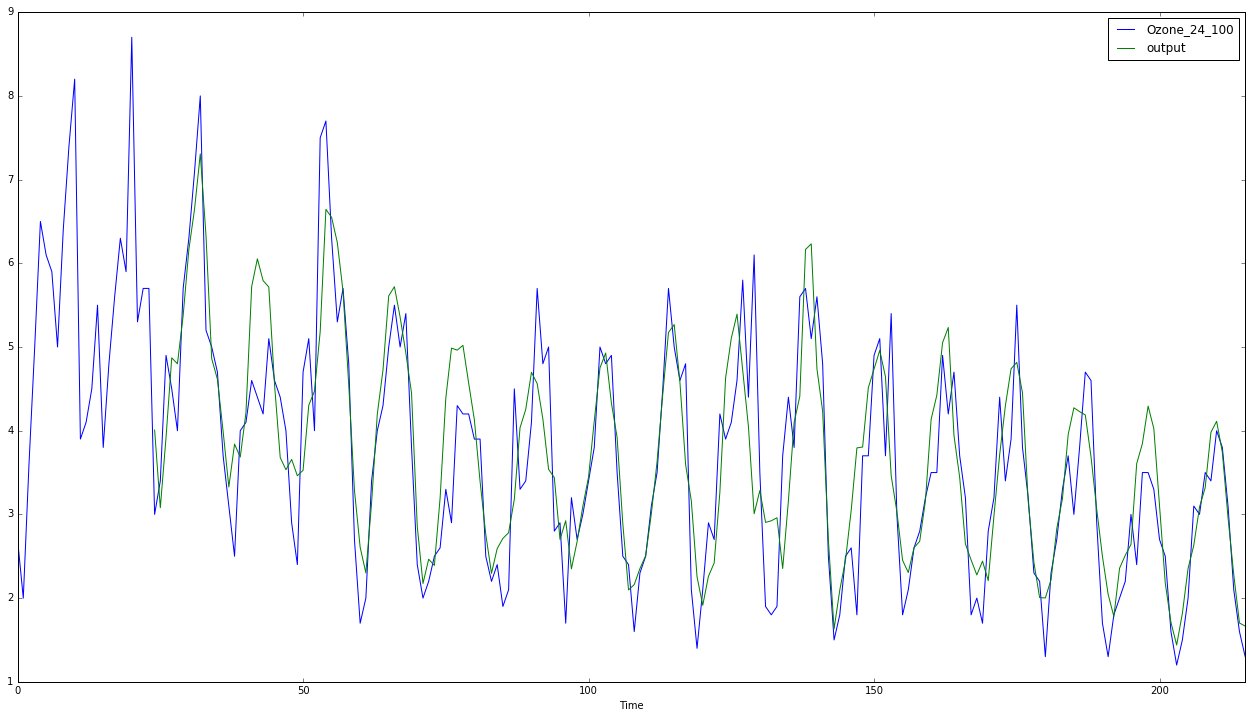

In [7]:
full_test('../data/ozone-la.csv', 'Ozone', 24, 100)

In [8]:
#for ep in [10 , 40, 160, 640]:
#    for lags in [8 ,32]:
#        full_test('../data/passengers_train.csv', 'AirPassengers',lags, ep)


/usr/lib/python3/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/lib/python3/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Train on 67 samples, validate on 17 samples
Epoch 1/100
0s - loss: 0.0348 - val_loss: 0.0205
Epoch 2/100
0s - loss: 0.0136 - val_loss: 0.0186
Epoch 3/100
0s - loss: 0.0102 - val_loss: 0.0094
Epoch 4/100
0s - loss: 0.0106 - val_loss: 0.0075
Epoch 5/100
0s - loss: 0.0096 - val_loss: 0.0195
Epoch 6/100
0s - loss: 0.0092 - val_loss: 0.0165
Epoch 7/100
0s - loss: 0.0037 - val_loss: 0.0064
Epoch 8/100
0s - loss: 0.0040 - val_loss: 0.0095
Epoch 9/100
0s - loss: 0.0087 - val_loss: 0.0079
Epoch 10/100
0s - loss: 0.0062 - val_loss: 0.0092
Epoch 11/100
0s - loss: 0.0046 - val_loss: 0.0173
Epoch 12/100
0s - loss: 0.0069 - val_loss: 0.0047
Epoch 13/100
0s - loss: 0.0058 - val_loss: 0.0049
Epoch 14/100
0s - loss: 0.0060 - val_loss: 0.0062
Epoch 15/100
0s - loss: 0.0030 - val_loss: 0.0030
Epoch 16/100
0s - loss: 0.0060 - val_loss: 0.0096
Epoch 17/100
0s - loss: 0.0039 - val_loss: 0.0027
Epoch 18/100
0s - loss: 0.0053 - val_loss: 0.0026
Epoch 19/100
0s - loss: 0.0040 - val_loss: 0.0061
Epoch 20/100
0s

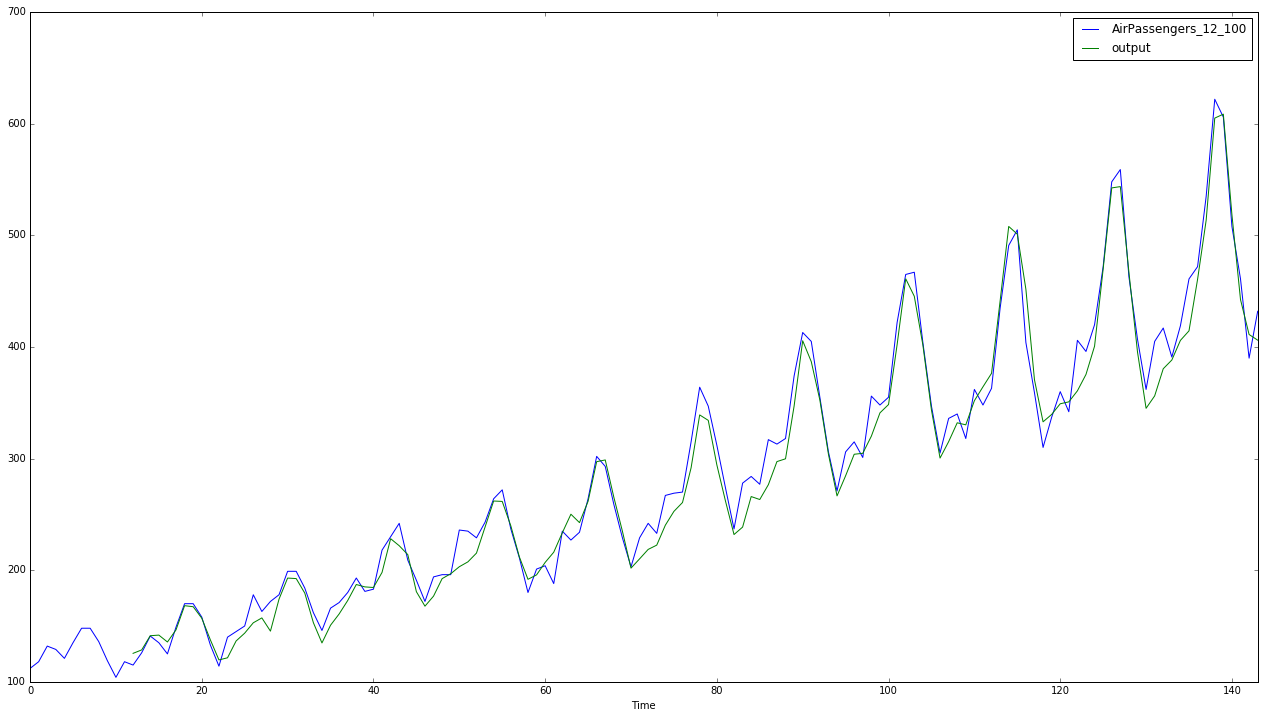

In [9]:
full_test('../data/passengers_train.csv', 'AirPassengers', 12, 100)

In [10]:
callbacks.EarlyStopping?

In [11]:
mod0 = Sequential()


In [12]:
mod0.fit?

In [13]:
LSTM?

In [14]:
mod0.compile(loss='mse', optimizer='adam')

Exception: Sequential model cannot be built: model is empty. Add some layers first.

In [15]:

def build_fake_model():
    model = Sequential()
    model.add(Dense(40, input_dim=5))
    # model.add(LSTM(40, input_dim=lags))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model;

In [16]:
mod0 = build_fake_model();

In [18]:
# mod0.__dict__

In [19]:
mod0.reset_states()

In [21]:
#mod0.__dict__

In [22]:
import copy;
mod1 = copy.deepcopy(mod0);

In [23]:
mod1.__dict__

{'_flattened_layers': None,
 '_output_mask_cache': {'140453775074416_94179042275360': None},
 '_output_shape_cache': {},
 '_output_tensor_cache': {},
 'built': True,
 'container_nodes': {'dense_5_ib-0',
  'dense_6_ib-0',
  'dense_input_3_ib-0',
  'dropout_3_ib-0'},
 'inbound_nodes': [<keras.engine.topology.Node at 0x7fbdf1537eb8>],
 'input_layers': [<keras.engine.topology.InputLayer at 0x7fbdf152fda0>],
 'input_layers_node_indices': [0],
 'input_layers_tensor_indices': [0],
 'input_names': ['dense_input_3'],
 'inputs': [dense_input_3],
 'layers': [<keras.layers.core.Dense at 0x7fbdf152fe48>,
 'loss': 'mse',
 'loss_weights': None,
 'metrics': [],
 'metrics_names': ['loss'],
 'metrics_tensors': [],
 'model': <keras.engine.training.Model at 0x7fbdf1537a90>,
 'name': 'sequential_4',
 'nodes_by_depth': {0: [<keras.engine.topology.Node at 0x7fbdf15320b8>],
  1: [<keras.engine.topology.Node at 0x7fbdf152ffd0>],
  2: [<keras.engine.topology.Node at 0x7fbdf152fe10>],
  3: [<keras.engine.topolog

In [24]:
mod1.reset_states()

In [25]:
mod1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_5 (Dense)                  (None, 40)            240         dense_input_3[0][0]              
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 40)            0           dense_5[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 1)             41          dropout_3[0][0]                  
Total params: 281
____________________________________________________________________________________________________


In [26]:
mod0.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_5 (Dense)                  (None, 40)            240         dense_input_3[0][0]              
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 40)            0           dense_5[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 1)             41          dropout_3[0][0]                  
Total params: 281
____________________________________________________________________________________________________


In [28]:
n0 = mod0.nodes_by_depth[0]
n1 = mod1.nodes_by_depth[0]


In [31]:
n0 , n1

([<keras.engine.topology.Node at 0x7fbdf159b518>],
 [<keras.engine.topology.Node at 0x7fbdf15320b8>])